# PDP - categorical variables

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we'll show how to calculate partial dependence plots for categorical variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Load data

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic_trees.csv')

df.head()

,pclass,sibsp,parch,sex,embarked,cabin,survived
0,1,0,0,0,0,0,1
1,1,1,2,1,0,1,1
2,1,1,2,0,0,1,0
3,1,1,2,1,0,1,0
4,1,1,2,0,0,1,0


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

X_train.shape, X_test.shape

((1112, 6), (197, 6))

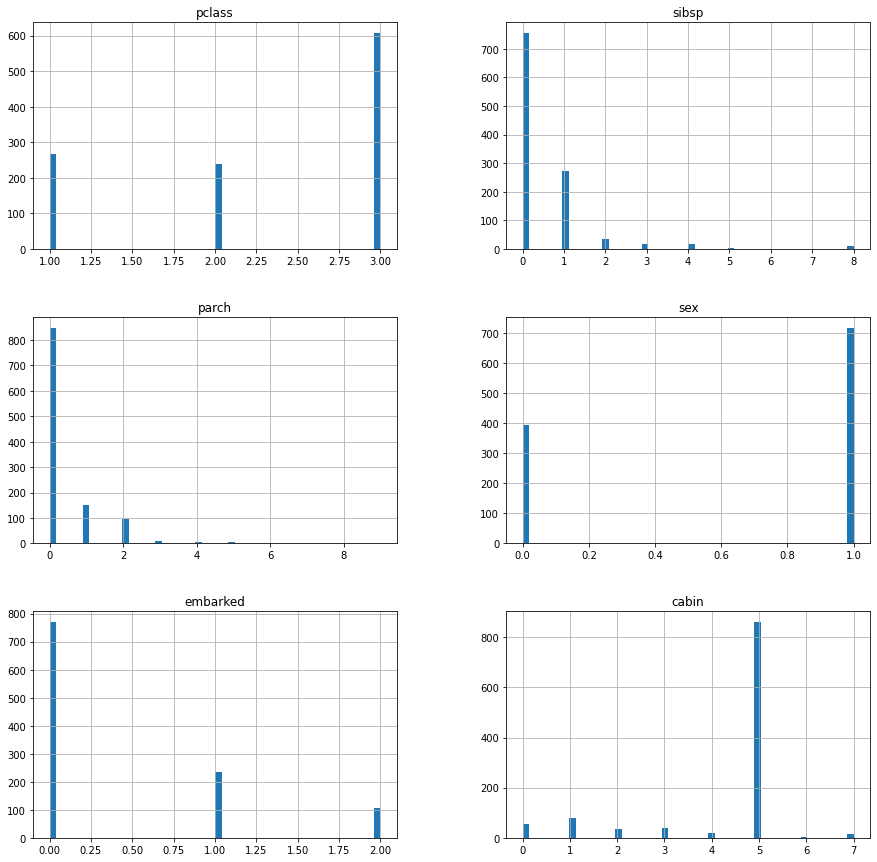

In [4]:
# Display the variables distribution

X_train.hist(bins=50, figsize=(15, 15))
plt.show()

pclass, sex and embarked are categorical variables.

## Random Forests

In [5]:
# fit model

rf =RandomForestClassifier(
    criterion="gini",
    n_estimators=25,
    max_depth=3,
    random_state=3,
)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=25, random_state=3)

In [6]:
# Accuracy in train set

rf.score(X_train, y_train)

0.789568345323741

In [7]:
# Accuracy in test set

rf.score(X_test, y_test)

0.8020304568527918

The model correctly predicts >78% of the outcomes.

In [8]:
baseline = 1 - y_train.mean()
baseline

0.6214028776978417

A baseline model that selects the majority class (not survived) has 62% accuracy. 

Our model has > 78%, which means that is better than the baseline, that is, better than just predicting the majority class.

## Tree derived feature importance

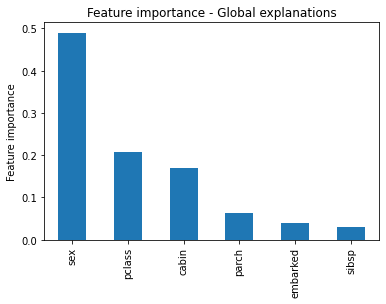

In [9]:
# random forest importance

global_exp = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)

global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

## Partial dependence plots

We will calculate the PDP for manually.

In [10]:
# Determine the PDP values to plot

pdp_preds = []

# make a copy not to overwrite the test set
X = X_test.copy()

# the unique values of the variable
categories = X["pclass"].unique()
categories.sort()

# set the value of pclass to each one of its categories
for value in categories:
    
    # Set the feature to a fixed value
    X["pclass"] = value
    
    # Obtain the predictions
    preds = rf.predict_proba(X)[:,1]
    
    # get the prediction average
    pdp_preds.append(np.mean(preds))

# the predictions average
pdp_preds

[0.46518375232243914, 0.42228107146592264, 0.3250287565726662]

In [11]:
# put data in a dataframe

pdp = pd.DataFrame({
    "pred": pdp_preds,
    "count": X_test.groupby(["pclass"])["pclass"].count(),
},
    index=categories)

pdp

,pred,count
1,0.465184,56
2,0.422281,39
3,0.325029,102


In [12]:
pdp.reset_index(inplace=True)

pdp

,index,pred,count
0,1,0.465184,56
1,2,0.422281,39
2,3,0.325029,102


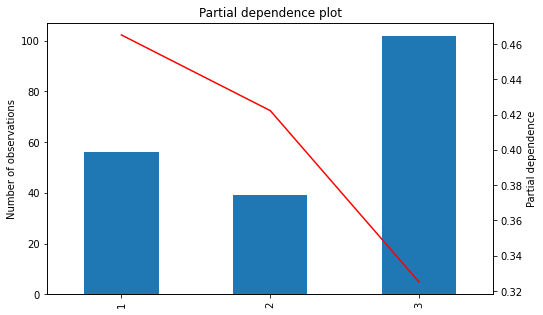

In [13]:
# Now we can plot the PDP over the count of 
# observations within each catgory

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
ax2 = ax.twinx()

pdp["count"].plot.bar(ax=ax)
pdp["pred"].plot(ax=ax2, color="r")

plt.title("Partial dependence plot")
ax.set_ylabel("Number of observations")
ax2.set_ylabel("Partial dependence")
plt.xticks(pdp.index, pdp["index"])
plt.show()

We see that the probability of survival decreases with the number of the class.  And we have a fair number of passengers on each class, so in principle we could trust those values for all classes.

In [14]:
# Let's put the code in a function

def plot_pdp(X, variable):
    
    # to avoid modifying the original dataframe
    X = X.copy()
    
    categories = X[variable].unique()
    categories.sort()
    
    pdp = pd.DataFrame({
    "count": X.groupby([variable])[variable].count(),
    }, index=categories)
    
    pdp_preds = []
    
    # calculate partial dependence
    for value in categories:

        # Set the feature to a fixed value
        X[variable] = value

        # Obtain the predictions
        preds = rf.predict_proba(X)[:,1]

        # get the prediction average
        pdp_preds.append(np.mean(preds))

    # the predictions average
    pdp["pred"] = pdp_preds
    
    pdp.reset_index(inplace=True)
    
    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pred"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    plt.xticks(pdp.index, pdp["index"])
    plt.show()

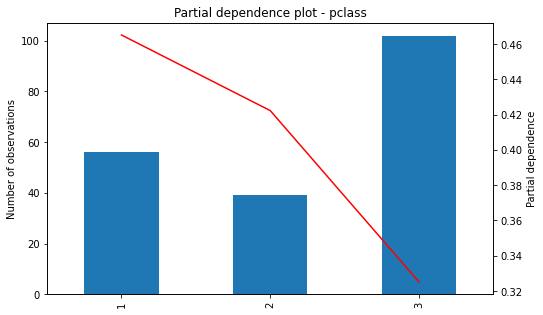

In [15]:
plot_pdp(X_test, "pclass")

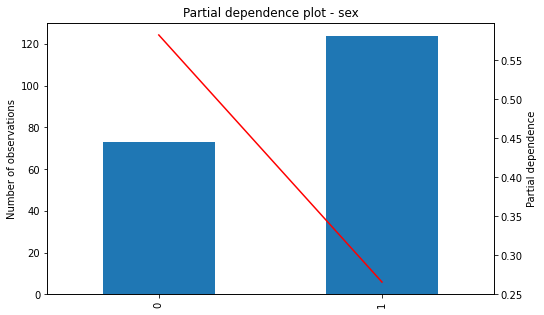

In [16]:
plot_pdp(X_test, "sex")

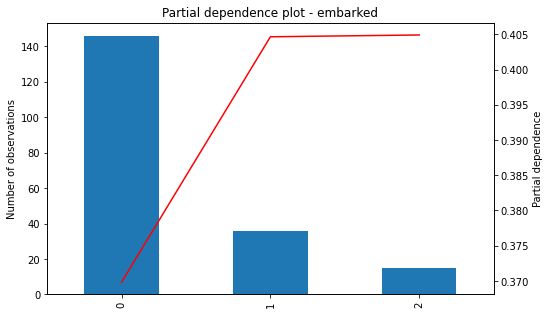

In [17]:
plot_pdp(X_test, "embarked")